# Extended data supporting the study of rundown modelling of L-type calcium current

This notebook provides supporting material that supplements the understanding of the methods undertaken and the results obtained in this study in Sections A and B.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import myokit
from IPython.display import Image
import os
import json
import scipy

import sys
sys.path.append('supporting')

import parameters
import helpers

### A. Supporting material for methods

Here we show how the experimental range for the channel density and radius was determined (A.1), show the analytical solution for diffusion of pure buffer inside a cell for our geography of interest (A.2), convergence test for the disretisation scheme adopted in the study (A.3), how the shape of peak calcium against time translates to the pattern of rundown-versus-time curve (A.4).


##### A.1 Experimental range of the L-type calcium channel (LCC) density and radius

###### A.1.1 L-type calcium channel (LCC) density 

We use the peak-ICaL recorded from previous experiments to estimate the range of the channel density ($P_{Ca}$).
From the previous study, we know that the peak-ICaL varies from -490.70 pA to -4444.386 pA.
A scatter plot of the same is shown below.

Max ICaL -490.7041936534882
Min ICaL -4444.386426318047


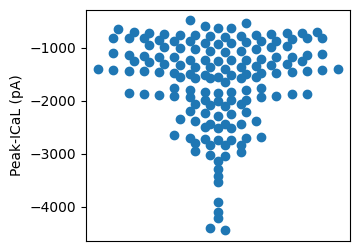

In [2]:
ical_peak = pd.read_csv('resources/all_peak_ical.csv').to_numpy().tolist()
ical_peak = [x[0] for x in ical_peak] # data in list format
print('Max ICaL', max(ical_peak))
print('Min ICaL', min(ical_peak))

x_swarm = helpers.simple_beeswarm(ical_peak)

plt.figure(figsize=(3.4, 3))
plt.scatter(x_swarm, ical_peak)
plt.ylabel('Peak-ICaL (pA)')
plt.xticks([])
plt.show()
plt.close()


We then simulate the model used in this study to determine the value of the entity given by $\delta * O$ at the step voltage-clamp protocol used for the experiment described in the main article.

Peak open probability times driving term: -99917.26633718854


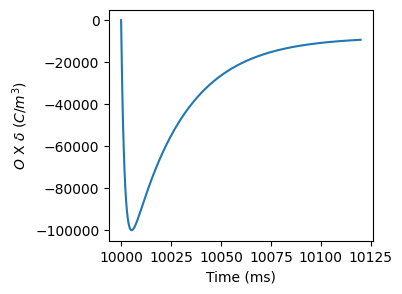

In [3]:
mod_path = 'resources/zeng-ical-template.mmt'
mod = myokit.load_model(mod_path)
pca = mod.get('L_type_Ca_current.P_Ca').pyfunc()()
mod.get('L_type_Ca_current.open_prob').set_rhs('d*f')
mod.get('calcium_dynamics.diffusion').set_rhs(0)
mod.get('calcium_dynamics.buffering').set_rhs(0)
mod.get('calcium_dynamics.current').set_rhs(0)
mod.get('membrane.V').set_binding(None)

s = myokit.Simulation(mod)
s.set_tolerance(abs_tol=1e-9, rel_tol=1e-09)
s.set_constant('membrane.V', -90)
s.run(10000, log=[]) # 10 seconds
s.set_constant('membrane.V', 0.001)
t = s.time()
times = np.arange(t, t+120, 0.1)
d = s.run(120, log=['L_type_Ca_current.i_CaL'], log_times = times)

op = np.divide(d['L_type_Ca_current.i_CaL'], pca)
#print('max op', max(op))
print('Peak open probability times driving term:', min(op))

plt.figure(figsize=(3.4, 3))
plt.plot(times, op)
plt.ylabel('$O$ X $\delta$ ($C/m^3$)')
plt.xlabel('Time (ms)')
plt.show()
plt.close()

By dividing the peak observed ICaL range with the peak open probability, we estimate that $P_{Ca}$ varies from 0.005 nL/s to 0.0444 nL/s.

###### A.1.2 Cell's radius

We similarly use the experimental recordings of the previous patch-clamp experiment to estimate the range of the cell's radius.
We used two methods for this purpose, first was to use the microscopic recordings and the second was the capacitance recordings.

In the first method, we used the radius of the cell measured under a microscope before the patch-clamp experiment was conducted.
In the second method, $R_0$ was estimated using the $C_m$ measured from the Syncropatch, by assuming that the specific capacitance of all cells was 1 microF/${cm}^{2}$ and the capacitance recorded corresponds to the total surface area of the cell ($3\pi R^2$).

The cell-range using each method is shown below and we take the exhaustive range estimated by all methods.

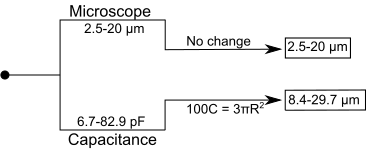

In [4]:
image_path = "supporting/flowchart_R.png"
Image(filename=image_path)

##### A.2 Diffusion of pure buffer inside a cell

An analytical solution was previously derived ([doi: 10.22489/CinC.2022.051](doi:10.22489/CinC.2022.051)) for the diffusion of pure buffer inside the cell for the geography of interest used in the main article.
The solution showed that the buffer concentration with space and time can be represented by a relationship of the dimensionless quantitites given by $u(x, \tau)$, $x$, and $\tau$.

The dimensionless quantities are given by: $u(x, \tau) = \frac{Br}{B_{max}R_h}$, $x = \frac{r - R_0}{R_h - R_0}$, and $\tau = \frac{D_Bt}{(R_h - R_0)^2}$.

The solution is given by

\begin{equation*}
    u(x, \tau) = \frac{hx - 1}{h-1} - \sum_{n=1}^{\infty}\frac{\alpha_n}{\beta_n} [\sin{\lambda_nx} -\frac{\lambda_n}{h}\cos{\lambda_nx}]\exp({-\lambda_n^2\tau}),
\end{equation*}
where,
\begin{equation*}
    \alpha_n = \frac{1}{h-1}\left[ \left (\frac{1}{h} + \frac{h}{\lambda_n^2} -1\right)\sin{\lambda_n} - \frac{h}{\lambda_n}\cos{\lambda_n}\right],
\end{equation*}

\begin{equation*}
    \beta_n = \frac{1}{2h^2}\left[\lambda_n^2 + h^2 + \frac{\lambda_n^2-h^2}{2\lambda_n}\sin{2\lambda_n} - 2h\sin^2{\lambda_n} \right],
\end{equation*}

and the roots of the solution ($\lambda_n$) are given by the positive roots of:

\begin{equation*}
    \tan{\lambda_n} = \frac{\lambda_n}{h}.
\end{equation*}

The figure below shows the concentration profile of the buffer at different snapshopts of time for a cell with the maximum possible radius used in this study ($40.6$ microm).

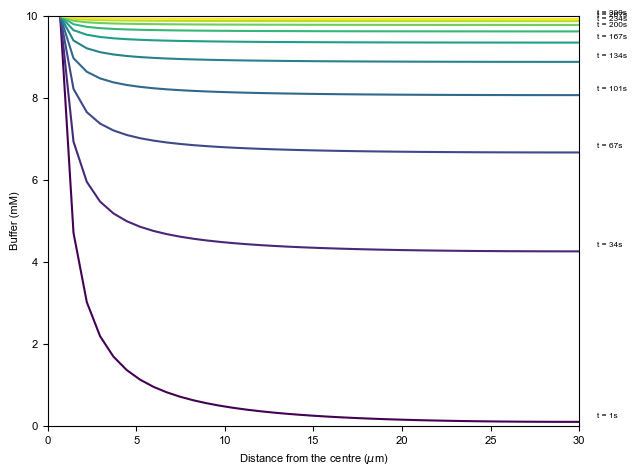

In [5]:
import analytical_solution
analytical_solution.plot_largest_r()

Next, we show the time taken for complete equilibration of the buffer for the range of the cell radius used in this study in the plot below.
We find that the relationship between size of the cell ($R_0$) and $t_{diff}$ is given by the equation below:

\begin{equation*}
t_{diff} = 0.0163R_0^3 - 0.019R_0^2 + 0.008R_0 - 0.016.
\end{equation*}

Therefore, $t_{diff}$ varies from 0.14s to 422.6s for cells with $R_0$ varying from 2.5 microm to 30 microm.

R min (um) 2.5 tdiff (s) 0.14464988000969856
R max (um) 30.0 tdiff (s) 422.6010489531189


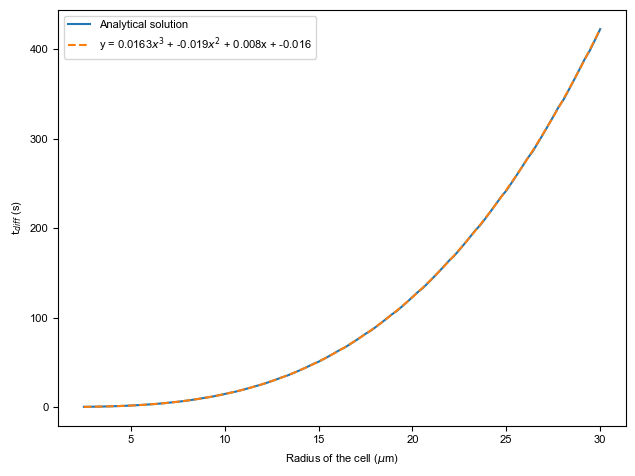

In [6]:
analytical_solution.plot_tau_max()

##### A.3 Convergence test
Next we use the analytical solutions to perform a convergence test to determine the minimum number of shells that a cell should be discretised into so that the resulting simulation has a very low error when compared to the true solution. 

For this test, a cell of the maximum possible radius, 30 microm, and the maximum time of interest (300s) was used to determine the convergence conditions for the `most difficult configuration'.

The left panel in the figure below shows the concentration profile of the free buffer using the derived analytical solution shown above, and discretisation of the equations described in the main text for varying values of $N$. 
We can see that the discretised simulations closely resemble the `true' solution.

We then calcualate the error in prediction for the outermost point corresponding to different shell width ($R_0/N$) and plot it on the right.
We calculate the absolute difference of the predicted buffer and the true solution and normalise it with respect to the true buffer concentration calculated from the analytical solution. 
The right panel in the figure below shows the convergence of error at smaller $L$ (larger $N$).

Simulations at all $N$ shown in this figure show negligible error.
We chose a shell width of approximately 0.05 microm ((30-1 microm)/600) as the minimum shell width that all numerical discretisations should have.
This ensures that the error in the buffer at any point is less than 0.15% (ln(0.0015)=-6.5).

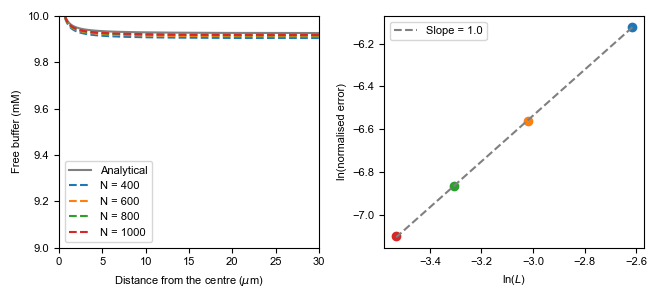

In [7]:
# run using convergence.py

image_path = "supporting/convergence.png"
Image(filename=image_path)

##### A.5 Map of rundown-versus-time curve on pattern of peak calcium against time

In this study, we are interested in the qualitative trends of the decay in current, therefore we show how the rundown-versus-time patterns observed for ICaL (linear, saturating, and inverse), translate to corresponding peak calcium trends.

When comparing the peak-ICaL and peak-Ca at successive sweeps, the voltage-dependent kinetics remains the same, and only $f_{Ca}$ changes, therefore the relationship can be written using a positive constant $\alpha$ as:
\begin{equation}
    I = - \alpha \cdot f_{Ca},
\end{equation}

\begin{equation}
    I = - \alpha \cdot \frac{1}{1 + [{Ca}^{2+}]/K_{IC50}},
\end{equation}

where $I$ is the peak-ICaL during the activation step.
This equation can be re-written as:
\begin{equation}
    [{Ca}^{2+}] = -K_{IC50}\left(1 + \frac{1}{I_{\text{\textit{norm}}}}\right),
\end{equation}
where, $I_{\text{\textit{norm}}}$ is the normalised current ${I}/{\alpha}$.

This equation can now be used to determine the qualitative trend of peak [Ca] corresponding to each pattern of rundown.
The top row of figure below shows different linear, saturating, and inverse functions which resemble the different patterns of rundown-versus-time plot.
These functions are taken as $I_{{{norm}}}$ and passed through the equation above to obtain the corresponding pattern of (peak [Ca])-versus time curve.

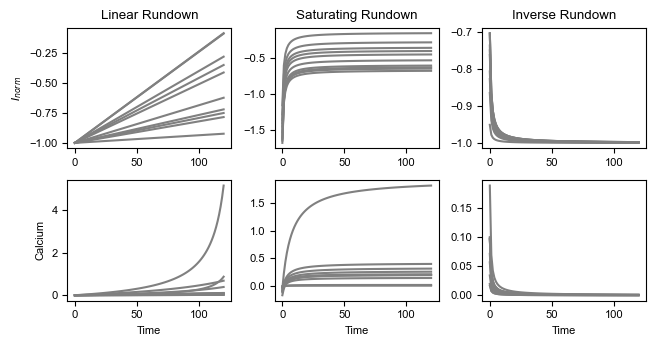

In [8]:
fig = plt.figure(figsize=(6.6, 3.5))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

ax1.set_ylabel('$I_{norm}$')
ax1.set_title('Linear Rundown')
ax4.set_ylabel('Calcium')
ax2.set_title('Saturating Rundown')
ax3.set_title('Inverse Rundown')
ax4.set_xlabel('Time')
ax5.set_xlabel('Time')
ax6.set_xlabel('Time')

t = np.linspace(0, 120, 100)
for _ in range(10):
    x = helpers.lin(t)
    ax1.plot(t, x, color = 'grey')
    ax4.plot(t, helpers.calcium(x), color = 'grey')
    x = helpers.logar(t)
    ax2.plot(t, x, color = 'grey')
    ax5.plot(t, helpers.calcium(x), color = 'grey')
    x = helpers.hyper(t)
    ax3.plot(t, x, color = 'grey')
    ax6.plot(t, helpers.calcium(x), color = 'grey')
    
plt.tight_layout()
plt.show()
plt.close()

This plot of shows that the rundown-versus-time patterns translate to (peak-calcium)-versus-time patterns as follows:
1) Linear rundown -> hyperbolic or linear shape of peak [Ca]-versus time
2) Saturating rundown -> saturating shape of peak [Ca]-versus time
3) Inverse rundown -> inverse shape shape of peak [Ca]-versus time

Finally, it is self-explanatory that for no rundown, there would correspondingly be no change in peak [Ca] across sweeps.

### B. Supporting material for results

Here we show that $\zeta$ can be accurately used to predict the rundown trend (B.1). 

##### B.1 $\zeta$ value and the corresponding rundown trend
From the main text we know that when $t_{diff}$ is the smallest time scale then the effect of rundown is negligible and when $t_0$ is the smallest, there is inverse rundown.

###### B.1.1 Accuracy of $\zeta$ when $t_{hold}$ is the smallest
Here we show the accuracy of $\zeta$ when $t_{hold}$ is the smallest.
For 1000 random draw of the three time constants - $t_0$, $t_{hold}$, and $t_{diff}$ in which $t_{hold}$ is the smallest of all time constants, we simulated the model to observe the rundown trend.
The $\zeta$ values and the rundown shapes are shown below.

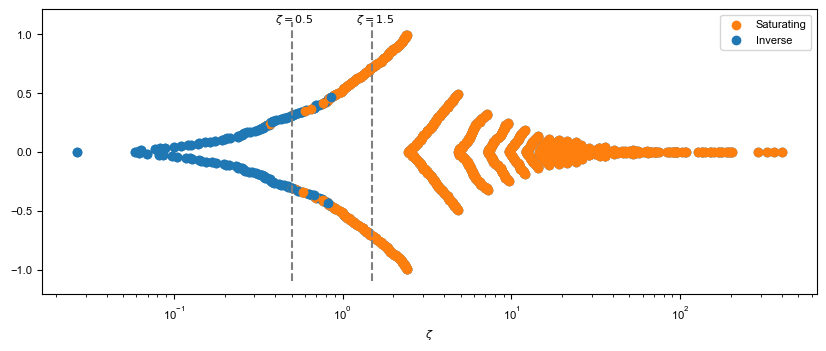

In [9]:
# zeta_accuracy.py

zeta_data = pd.read_csv('supporting/zeta_accuracy_thold.txt', sep = " | ", engine='python')
zeta = zeta_data['zeta']
trend = zeta_data['trend']
thold = zeta_data['thold']
tdiff = zeta_data['tdiff']
t0 = zeta_data['t0']

y_arr = helpers.simple_beeswarm(zeta.to_list())


plt.figure(figsize=(10, 3.7))
plt.scatter(zeta, y_arr)
for i in range(len(zeta)):
    ts = [thold[i], tdiff[i], t0[i]]
    if min(ts) == thold[i]:
        if trend[i] == 'saturating':
            plt.scatter(zeta[i], y_arr[i], color = 'tab:orange')
        else:
            plt.scatter(zeta[i], y_arr[i], color = 'tab:blue')

        
plt.vlines(1.5, ymin = -1.1, ymax = 1.1, ls = '--', color='grey')
plt.vlines(0.5, ymin = -1.1, ymax = 1.1, ls = '--', color='grey')
plt.scatter([], [], color = 'tab:orange', label = 'Saturating')
plt.scatter([], [], color = 'tab:blue', label = 'Inverse')
plt.text(0.4, 1.1, "$\zeta = 0.5$")
plt.text(1.2, 1.1, "$\zeta = 1.5$")
plt.xlabel("$\zeta$")

plt.xscale('log')
plt.legend(loc='best')
plt.show()
plt.close()


In [10]:
# What happens in between

count_sat = 0
count_inv = 0

for i in range(len(zeta)):
    if zeta[i] < 1.5:
        if zeta[i] > 0.5:
            if trend[i] == 'saturating':
                count_sat += 1
            else:
                count_inv += 1

print(f'Between the thresholds, there is {100*count_sat/(count_sat + count_inv)}% of saturating tend')
print(f'Between the thresholds, there is {100*count_inv/(count_sat + count_inv)}% of inverse tend')

Between the thresholds, there is 80.15873015873017% of saturating tend
Between the thresholds, there is 19.841269841269842% of inverse tend


The plot shows that for most saturating scenarios, $\zeta$ is greater than 4.5, and for most inverse scenarios, $\zeta$ is less than 1.5.
The accuracy of $\zeta$ is given below.

In [11]:
thold_accuracy = []
for i in range(len(zeta)):
    ts = [thold[i], tdiff[i], t0[i]] 
    if min(ts) == thold[i]:
        if trend[i] == 'saturating':
            if zeta[i] > 1.5:
                thold_accuracy.append(1)
            elif zeta[i] < 0.5:
                thold_accuracy.append(0)
        else:
            if zeta[i] > 1.5:
                thold_accuracy.append(0)
            elif zeta[i] < 0.5:
                thold_accuracy.append(1)
    else:
        continue

perc = 100*sum(thold_accuracy)/len(thold_accuracy)
print('Accuracy of zeta prediction is:', perc, '%')
print('Number of samples is:', len(thold_accuracy) )

Accuracy of zeta prediction is: 99.77142857142857 %
Number of samples is: 875


###### B.1.2 Accuracy of $\zeta$ when $t_{diff}$ is the smallest

Although there is usually negligible rundown due to CDI when $t_{diff}$ is the minimum, we repeat the study above for when $t_{diff}$ is the minimum instead of $t_{hold}$

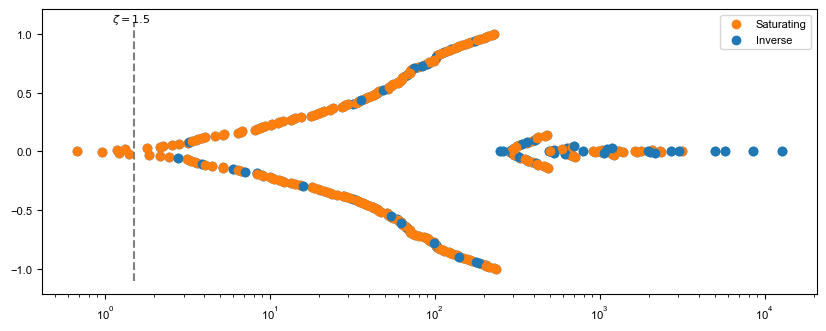

In [12]:
# Results of the case when tdiff is the smallest here
zeta_data_arr = pd.read_csv('supporting/zeta_accuracy_tdiff.txt', sep = " | ", engine='python')
zeta_arr = zeta_data_arr['zeta']
trend_arr = zeta_data_arr['trend']
thold_arr = zeta_data_arr['thold']
tdiff_arr = zeta_data_arr['tdiff']
t0_arr = zeta_data_arr['t0']

y_arr = helpers.simple_beeswarm(zeta_arr.to_list())


plt.figure(figsize=(10, 3.7))
plt.scatter(zeta_arr, y_arr)
for i in range(len(zeta_arr)):
    ts = [thold_arr[i], tdiff_arr[i], t0_arr[i]]
    if min(ts) == tdiff_arr[i]:
        if trend_arr[i] == 'saturating':
            plt.scatter(zeta_arr[i], y_arr[i], color = 'tab:orange')
        else:
            plt.scatter(zeta_arr[i], y_arr[i], color = 'tab:blue')

        
# plt.vlines(0.5, ymin = -1.1, ymax = 1.1, ls = '--', color='grey')
plt.vlines(1.5, ymin = -1.1, ymax = 1.1, ls = '--', color='grey')
plt.scatter([], [], color = 'tab:orange', label = 'Saturating')
plt.scatter([], [], color = 'tab:blue', label = 'Inverse')
plt.text(1.1, 1.1, "$\zeta = 1.5$")
# plt.text(3.5, 1.1, "$\zeta = 4.5$")

plt.xscale('log')
plt.legend(loc='best')
plt.show()
plt.close()


The accuracy of $\zeta$ is much lower here compared to when $t_{hold}$ was the minimum, but it is still approximately 80% as computed below

In [13]:
thold_accuracy = []
for i in range(len(zeta_arr)):
    ts = [thold_arr[i], tdiff_arr[i], t0_arr[i]] 
    if min(ts) == tdiff_arr[i]:
        if trend_arr[i] == 'saturating':
            if zeta_arr[i] > 1.5:
                thold_accuracy.append(1)
            elif zeta_arr[i] < 0.5:
                thold_accuracy.append(0)
        else:
            if zeta_arr[i] > 1.5:
                thold_accuracy.append(0)
            elif zeta_arr[i] < 0.5:
                thold_accuracy.append(1)
    else:
        continue

perc = 100*sum(thold_accuracy)/len(thold_accuracy)
print('Accuracy of zeta prediction is:', perc, '%')
print('Number of samples is:', len(thold_accuracy) )

Accuracy of zeta prediction is: 79.7427652733119 %
Number of samples is: 311


###### B.1.2 Accuracy of $\zeta$ when $t_{0}$ is the smallest

Additionally, we show below that when $t_0$ is the smallest, then $\zeta$ is almost always less than 0.5

In [14]:

n = 1000000 # 1 million

zeta_arr = []
count_t = 0

count = 0

while count_t < n:
    found_p = False
    while found_p == False:
        thold, t0, tdiff = helpers.draw_t() # milli seconds
        t_const = [thold, t0, tdiff]
        if min(t_const) == t0:
            found_p = True

    count_t += 1
    zeta = (t0/tdiff) * (t0/thold)
    zeta_arr.append(zeta)

    if zeta > 0.5:
        count += 1

print(f"Probability of zeta being > 0.5 when t0 is the minimum: {100*count/n}%")

Probability of zeta being > 0.5 when t0 is the minimum: 1.9474%


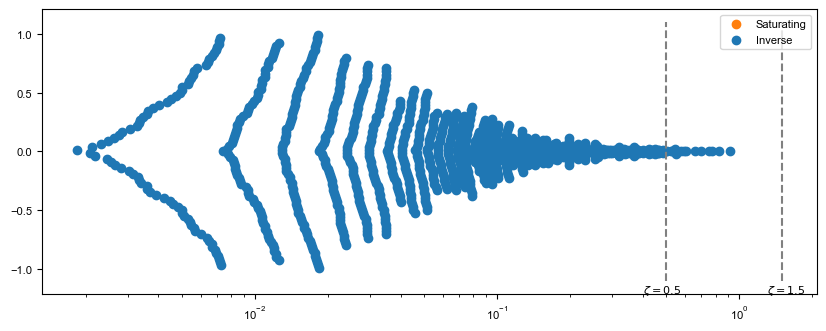

In [15]:
# Results of the case when t0 is the smallest here
zeta_data_arr = pd.read_csv('supporting/zeta_accuracy_t0.txt', sep = " | ", engine='python')
zeta_arr = zeta_data_arr['zeta']
trend_arr = zeta_data_arr['trend']
thold_arr = zeta_data_arr['thold']
tdiff_arr = zeta_data_arr['tdiff']
t0_arr = zeta_data_arr['t0']

y_arr = helpers.simple_beeswarm(zeta_arr.to_list())


plt.figure(figsize=(10, 3.7))
plt.scatter(zeta_arr, y_arr)
for i in range(len(zeta_arr)):
    ts = [thold_arr[i], tdiff_arr[i], t0_arr[i]]
    if min(ts) == tdiff_arr[i]:
        if trend_arr[i] == 'saturating':
            plt.scatter(zeta_arr[i], y_arr[i], color = 'tab:orange')
        else:
            plt.scatter(zeta_arr[i], y_arr[i], color = 'tab:blue')

        
plt.vlines(1.5, ymin = -1.1, ymax = 1.1, ls = '--', color='grey')
plt.vlines(0.5, ymin = -1.1, ymax = 1.1, ls = '--', color='grey')
plt.scatter([], [], color = 'tab:orange', label = 'Saturating')
plt.scatter([], [], color = 'tab:blue', label = 'Inverse')
plt.text(0.4, -1.2, "$\zeta = 0.5$")
plt.text(1.3, -1.2, "$\zeta = 1.5$")

plt.xscale('log')
plt.legend(loc='best')
plt.show()
plt.close()


In [16]:
thold_accuracy = []
for i in range(len(zeta_arr)):
    ts = [thold_arr[i], tdiff_arr[i], t0_arr[i]] 
    if min(ts) == t0_arr[i]:
        if trend_arr[i] == 'saturating':
            if zeta_arr[i] > 1.5:
                thold_accuracy.append(1)
            elif zeta_arr[i] < 0.5:
                thold_accuracy.append(0)
        else:
            if zeta_arr[i] > 1.5:
                thold_accuracy.append(0)
            elif zeta_arr[i] < 0.5:
                thold_accuracy.append(1)
    else:
        continue

perc = 100*sum(thold_accuracy)/len(thold_accuracy)
print('Accuracy of zeta prediction is:', perc, '%')
print('Number of samples is:', len(thold_accuracy) )

Accuracy of zeta prediction is: 90.35532994923858 %
Number of samples is: 985
